<a href="https://colab.research.google.com/github/keran-w/3d-deep-learning/blob/main/Notebooks/Multi_View_Bitmap_Classification_Using_Octree_Based_Representations_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Draft Version \#1

# Imports

In [1]:
# !pip install lightning

In [2]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm import tqdm
from google.colab import drive
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport
from matplotlib.animation import FuncAnimation

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

# import lightning.pytorch as pl

import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
drive.mount('/content/drive', force_remount=True)
clear_output()

In [4]:
dataset_name = 'modelnet40'
%cd /content/drive/MyDrive/dataset/{dataset_name}
base_path = Path('.')

/content/drive/MyDrive/dataset/modelnet40


# Data and Visualization

In [5]:
# we only use files that are existed
metadata = pd.read_csv(base_path/'metadata_modelnet40.csv')

dataset_dir = base_path/'ModelNet40-path'
all_files = [f[len(str(dataset_dir))+1:] 
            for f in glob.glob(f'{dataset_dir}/*/*/*')]
# metadata_ = metadata.query('`class` in @all_labels')
metadata.object_path = metadata.object_path.\
                        str.replace('.off', '.path', regex=True)
metadata = metadata.query('`object_path` in @all_files')
# ProfileReport(metadata, minimal=True, dark_mode=True).to_notebook_iframe()

In [6]:
train_metadata = metadata.query('split == "train"')
test_metadata = metadata.query('split == "test"')

In [7]:
train_paths = [dataset_dir/fp for fp in train_metadata.object_path]
train_labels = train_metadata['class']
test_paths = [dataset_dir/fp for fp in test_metadata.object_path]
test_labels = test_metadata['class']

In [9]:
num_labels = len(set(train_labels))
num_labels

29

In [ ]:
# all_labels = [label for label in os.listdir(base_path/'ModelNet40-path') 
                    # if os.path.isfile(base_path/f'ModelNet40-path/{label}/train/{label}_0001.path')]
# num_labels = len(all_labels)

In [10]:
def load_path(file_path):
    path_graph = open(file_path, 'r').read().split('\n')[1:]
    num_vert, num_edge = [int(i) for i in path_graph[0].split()]
    verts = [[float(v_s) for v_s in v_str.split()] for v_str in path_graph[1:num_vert+1]]
    edges = [[int(e_s) for e_s in e_str.split()] for e_str in path_graph[num_vert+1:]][:-1]
    verts = np.array(verts)
    return verts, edges
  
file_path = metadata.object_path[0].replace('.off', '.path')
verts, edges = load_path(dataset_dir/file_path)

100%|██████████| 11678/11678 [00:15<00:00, 748.23it/s]


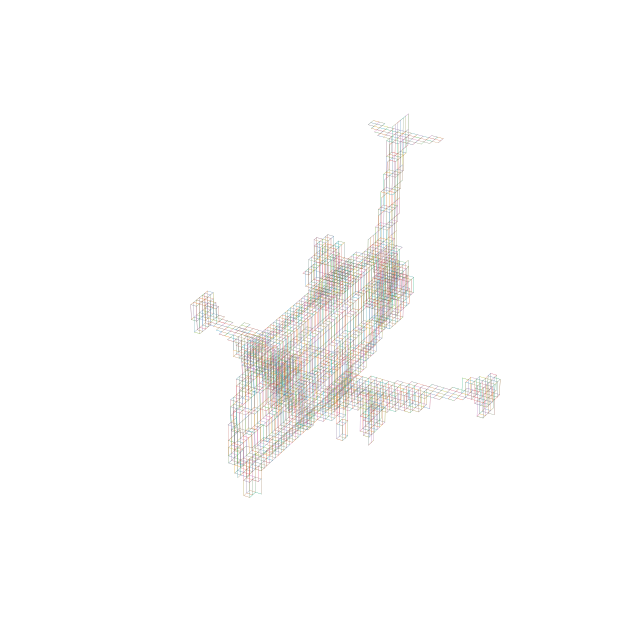

In [11]:
def visualize(verts, edges):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    for edge in tqdm(edges):
        ax.plot(
            [verts[edge[0], 0], verts[edge[1], 0]],
            [verts[edge[0], 1], verts[edge[1], 1]],
            [verts[edge[0], 2], verts[edge[1], 2]],
            linewidth=0.1,
        )
    ax.axis('off')
    plt.show()

visualize(verts, edges)

In [12]:
def get_bitmap(verts, axis, round=2):
    verts_ = (np.round(verts, 2) * 100).astype('int')
    bitmap = np.zeros((100,100))
    for i,j in verts_[:,axis]:
        bitmap[i,j] += 1
    return bitmap / np.max(bitmap)

bitmap_0 = get_bitmap(verts, [0,1])
bitmap_1 = get_bitmap(verts, [1,2])
bitmap_2 = get_bitmap(verts, [2,0])

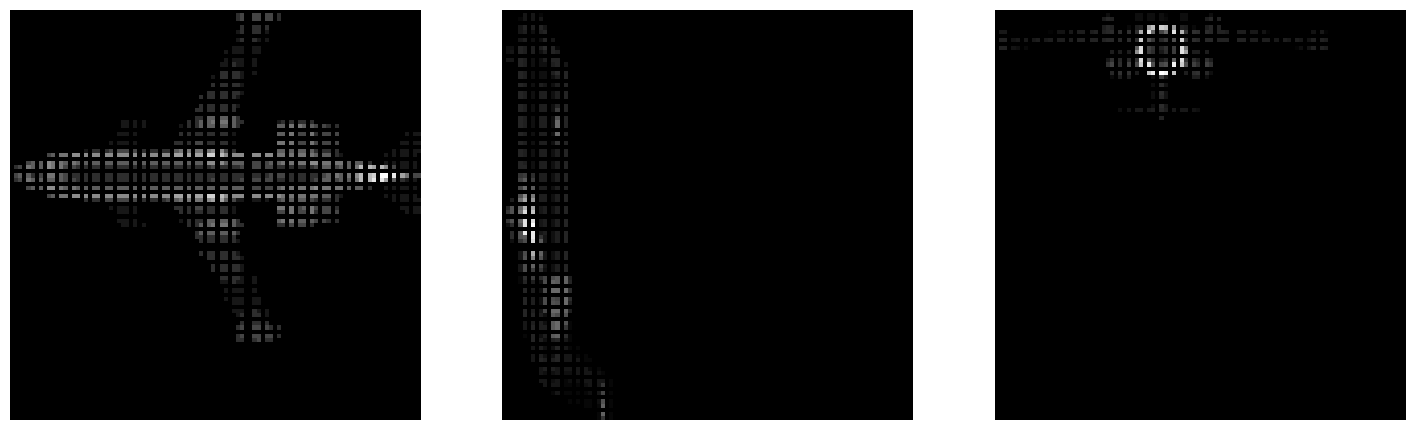

In [13]:
def visualize_bitmap(ax, bitmap):
    ax.imshow(bitmap, cmap='gray')
    ax.axis('off')

fig, ax = plt.subplots(1,3, figsize=(18,6))
visualize_bitmap(ax[0], bitmap_0)
visualize_bitmap(ax[1], bitmap_1)
visualize_bitmap(ax[2], bitmap_2)
plt.show()

In [14]:
def get_bitmap(verts, axis, precision=7):
    verts_ = (np.round(verts*2**precision)).astype('int')
    bitmap = np.zeros((2**precision,2**precision))
    for i,j in verts_[:,axis]:
        bitmap[i,j] += 1
    return bitmap / np.max(bitmap)

def get_bitmaps(verts, edges):
    bm1 = get_bitmap(verts, [0,1]).tolist()
    bm2 = get_bitmap(verts, [1,2]).tolist()
    bm3 = get_bitmap(verts, [2,0]).tolist()
    return [bm1, bm2, bm3]

# convert data to bitmaps
train_data = [get_bitmaps(*load_path(fp)) for fp in tqdm(train_paths)]

100%|██████████| 6871/6871 [46:57<00:00,  2.44it/s]


In [18]:
test_data = [get_bitmaps(*load_path(fp)) for fp in tqdm(test_paths)]

100%|██████████| 1535/1535 [11:07<00:00,  2.30it/s]


In [37]:
with open('saved_data/test_dataset.pkl', 'wb') as f:
   pickle.dump((test_data, test_labels.tolist()), f)

In [36]:
with open('saved_data/train_dataset.pkl', 'wb') as f:
   pickle.dump((train_data, train_labels.tolist()), f)

# Dataset

In [ ]:
# class bitmapDataset(Dataset):
#     def __init__(self, metadata, all_labels, dataset_dir, mode, test_size=0.15):
#         assert mode in ('train', 'valid', 'test')
#         self.labels = all_labels
#         le = LabelEncoder().fit(all_labels)
#         self.label_map = dict((zip(le.classes_, le.transform(le.classes_))))

#         all_files = [f[len(str(dataset_dir))+1:] 
#                     for f in glob.glob(f'{dataset_dir}/*/*/*')]
#         metadata_ = metadata.query('`class` in @all_labels')
#         metadata_.object_path = metadata_.object_path.\
#                                 str.replace('.off', '.path', regex=True)
#         metadata_ = metadata_.query('`object_path` in @all_files')

#         train_data = metadata_.query('split == "train"')
#         test_data = metadata_.query('split == "test"')
#         train_data, valid_data = train_test_split(train_data,
#                                                   stratify=train_data['class'], 
#                                                   test_size=test_size)
#         self.train_paths = train_data.object_path.tolist()
#         self.train_labels = train_data['class'].tolist()
#         self.valid_paths = valid_data.object_path.tolist(), 
#         self.valid_labels = valid_data['class'].tolist()
#         self.test_paths = test_data.object_path.tolist()
#         self.test_labels = test_data['class'].tolist()
#         self.mode = mode
#         self.dataset_dir = dataset_dir

#     def __len__(self):
#         return eval(f'len(self.{self.mode}_paths)')
    
#     def __getitem__(self, index):
#         path = eval(f'self.{self.mode}_paths')[index].replace('off', 'path')
#         label = eval(f'self.{self.mode}_labels')[index]
#         bitmaps = get_bitmaps(*load_path(self.dataset_dir/path))

#         item = {
#             'mode': self.mode,
#             'X': torch.tensor(bitmaps).float(),
#             'y': self.label_map[label]
#         }

#         return item

# def get_loader(metadata, all_labels, dataset_dir, mode, batch_size=128, shuffle=False):
#     return DataLoader(bitmapDataset(metadata, all_labels, dataset_dir, mode), batch_size=batch_size, shuffle=shuffle)

# train_dataset = bitmapDataset(metadata, all_labels, dataset_dir, 'train')
# valid_dataset = bitmapDataset(metadata, all_labels, dataset_dir, 'valid')
# test_dataset = bitmapDataset(metadata, all_labels, dataset_dir, 'test')
# train_loader = get_loader(metadata, all_labels, dataset_dir, 'train', shuffle=True)
# valid_loader = get_loader(metadata, all_labels, dataset_dir, 'valid', shuffle=False)
# test_loader = get_loader(metadata, all_labels, dataset_dir, 'test', shuffle=False)

In [ ]:
# sample_batch = next(iter(train_loader))
# sample_batch['X'].shape, sample_batch['y'].shape

# Model

In [ ]:
class MVNet(nn.Module):
    def __init__(self, num_classes):
        super(MVNet, self).__init__()
        self.conv1 = nn.LazyConv2d(out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


# test model for sample batch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = MVNet(num_labels)
# model.eval()
# y_pred = model(sample_batch['X'])
# criterion = nn.CrossEntropyLoss()
# criterion(y_pred, sample_batch['y'])
device

'cuda'

# Trainer

In [ ]:
# Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [ ]:
model = MVNet(num_labels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 10

for epoch in range(n_epoch):
    model.train()
    train_pbar = tqdm(train_loader)
    train_pbar.set_description_str(f'[ Train {epoch+1:03d}/{n_epoch:03d} ]')
    loss_list, acc_list = [], []
    for batch in train_pbar:
        # loss = train_step(model, optimizer, criterion, batch, device)
        optimizer.zero_grad()
        logits = model(batch['X'].to(device))
        true_labels = batch['y'].long().to(device)
        loss = criterion(logits, true_labels)
        loss.backward()
        optimizer.step()
        train_pbar.set_postfix_str(f'loss: {loss}')
        loss_list.append(loss.item())
        break
        # scheduler.step()

    model.eval()
    with torch.no_grad():
        valid_pbar = tqdm(train_loader)
        valid_pbar.set_description_str(f'[ Valid {epoch+1:03d}/{n_epoch:03d} ]')
        for batch in valid_pbar:
            # results = valid_step(model, batch, metrics, device)
            logits = model(batch['X']).detach()
            true_labels = batch['y'].long().to(device)

            results = {}
            metric = 'acc'
            results[metric] = (logits.argmax(1) == true_labels).float().mean().item()
            valid_pbar.set_postfix_str(f'{" ".join([f"{k}: {v}" for k, v in results.items()])}')
            acc_list.append(results['acc'])
            break

    print(f'Average train loss: {np.mean(loss_list):.4f} Average test accuracy: {np.mean(acc_list):.3f}')
        

In [ ]:
class MVClassifier(pl.LightningModule):
    def __init__(self, MVNet):
        super().__init__()
        self.forward = MVNet

    def training_step(self, batch, batch_idx):
        x, y = batch['X'], batch['y']
        y_pred = self.MVNet(x)
        loss = nn.functional.mse_loss(y_pred, y)
        # Logging to TensorBoard (if installed) by default
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch['X'], batch['y']
        y_hat = self.forward(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

model = MVClassifier(MVNet(num_labels))
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model, train_loader, valid_loader)